In [1]:
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import clear_output
from numfluxes import *

We will add Strong Stability Preserving Runge-Kutta scheme of third order(SSP RK3 scheme) to https://github.com/cpraveen/numpde/tree/master/claw1d
The SSP RK3 scheme is given by 
\begin{align*}
v^{(0)} &= v^n \\
v^{(1)} &= v^{(0)} + \Delta t L(v^{(0)}) \\
v^{(2)} &= \frac 34 v^{(0)} + \frac 14 [v^{(1)} +\Delta t L(v^{(1)})] \\
v^{(3)} &= \frac 13 v^{(0)} + \frac 23 [v^{(2)} + \Delta t L(v^{(2)})] \\
v^{n+1} &= v^{(3)}
\end{align*}

The first update is nothing but forward Euler to go from $v^n$ to $v^{n+1}$, and the updates following it do do forward Euler and take average with $v^n$. I guess the process of taking weighted averages is what adds stability and higher order accuracy.

Notice that the relevant coefficients from the second term onwards are $\{0,1\}, \left\{\frac 34, 1-\frac 34 = \frac 14 \right\}, \left\{ \frac 13, 1-\frac 34= \frac 23 \right\}$. 

Thus, we can specify the scheme simply by specifying these coefficients

In [13]:
nrk = 3                    #Order of rk scheme
ark = [0.0,3.0/4.0,1.0/3.0] #Coefficients of rk scheme

In [14]:
def shock(x):
    u = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < 0.25:
            u[i] = 2.0
        else:
            u[i] = 1.0
    return u

def smooth(x):
    return np.sin(2*np.pi*x)

def rare(x):
    u = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < 0.5:
            u[i] = -0.5
        else:
            u[i] = 1.0
    return u

def expo(x):
    return 1.0 + np.exp(-100*(x-0.25)**2)

In [15]:
N = 100
cfl = 0.4
scheme = 'GOD'
Tf = 0.5

In [16]:
if scheme  =='LF':
    flux = flux_lf
elif scheme=='LLF':
    flux = flux_llf
elif scheme=='LW':
    flux = flux_lw
elif scheme=='ROE':
    flux = flux_roe
elif scheme=='EROE':
    flux = flux_eroe
elif scheme=='GOD':
    flux = flux_god
else:
    print("Unknown scheme: ", scheme)
    assert(False)

In [17]:
uinit = shock
xmin, xmax = 0.0, 1.0

x = np.linspace(xmin, xmax, N)
h = (xmax - xmin)/(N-1)
u_init = uinit(x)
dt= cfl * h / np.max(u_init)
lam = dt/h
scheme = 'GOD'
bc = 'dirichlet'

<IPython.core.display.Javascript object>


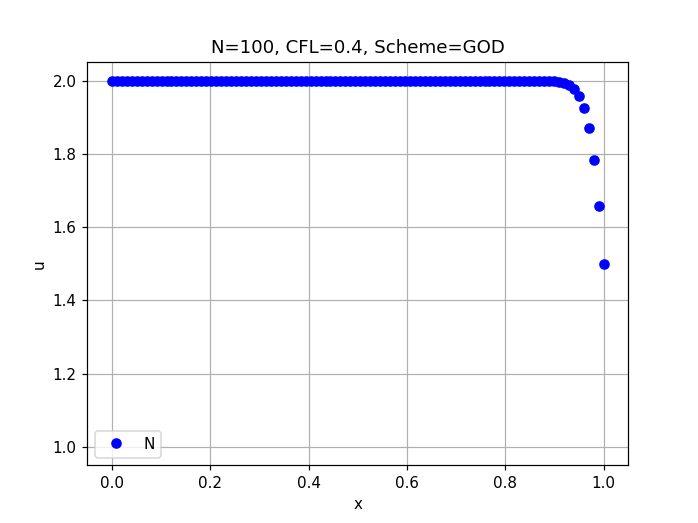

In [29]:
plt.ion()
fig = plt.figure()
gs  = gridspec.GridSpec(1,1,width_ratios=[1],hspace=0.3,wspace=0.3)
ax = plt.subplot(gs[0])
line1, = ax.plot(x,u_init,'ob')
#line2, = ax.plot(x,uinit,'r')
ax.set_xlabel('x');ax.set_ylabel('u')
ax.set_title('N='+str(N)+', CFL='+str(cfl)+', Scheme='+scheme)
plt.legend(('Numerical Solution'))
plt.grid(True)
plt.gcf().canvas.draw()
plt.show()
   
#solve(args.N, args.cfl, args.scheme, args.Tf, smooth)

In [30]:
def compute_res(u):
    f = flux(lam,u)
    residual = np.zeros(len(u))
    residual[1:] = (f[2:]-f[1:-1])
    return residual

In [31]:
t, it = 0.0, 0
u    = u_init.copy()
uold = u_init.copy()
while t < Tf:
    #Dirichlet bc will fix the first value. We compute the rest using scheme.
    uold[:] = u
    for rk in range(nrk):
        residual = compute_res(u)
        u[1:]    = ark[rk]*uold[1:]+(1.0-ark[rk])*(u[1:]-lam*residual[1:])
    t += dt; it += 1
    clear_output(wait=True)
    print("it,t,umin,umax = %4d %12.4e %12.4e %12.4e" % (it,t,u.min(),u.max()))
    line1.set_ydata(u)
    #line2.set_ydata(uexact(x,t))
    plt.gcf().canvas.draw()
    plt.pause(0.1)
plt.show()

it,t,umin,umax =  248   5.0101e-01   1.4999e+00   2.0000e+00
